<a href="https://colab.research.google.com/github/kcbharat100/covid-19-detection-using-x-rays/blob/master/transfer_learning_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ACCESSING DATASET FROM GITHUB REPO:

!git clone https://github.com/kcbharat100/covid-19-detection-using-x-rays.git

Cloning into 'covid-19-detection-using-x-rays'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3149 (delta 0), reused 0 (delta 0), pack-reused 3146
Receiving objects: 100% (3149/3149), 894.19 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (1914/1914), done.


In [2]:
#PREPARING BALANCED DATASET

import os
import shutil
import random

random.seed(1234)
       
def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def select_copy_randomly(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)

def copy_directory_files(input_dir, output_dir):
    files = get_file_list(input_dir)
    copy_files(files, input_dir, output_dir)

def file_count(dir):
  path, dirs, files = next(os.walk(dir))
  return len(files)

input_dir_normal = 'covid-19-detection-using-x-rays/dataset_binary/normal'
input_dir_covid = 'covid-19-detection-using-x-rays/dataset_binary/covid'
output_dir_normal = 'dataset/normal'
output_dir_covid = 'dataset/covid'

if not os.path.exists(output_dir_normal):
    os.makedirs(output_dir_normal)
if not os.path.exists(output_dir_covid):
    os.makedirs(output_dir_covid)
    
#select and copy randomly 206 images from github dataset to new directory- dataset
select_copy_randomly(input_dir_normal, output_dir_normal, 206)
print("Normal files count:")
print(str(file_count(output_dir_normal)))

#copy all 206 images from imported github dataset to new directory - dataset
copy_directory_files(input_dir_covid, output_dir_covid )
print("Covid files count:")
print(str(file_count(output_dir_covid)))
print('Done!')

Normal files count:
206
Covid files count:
206
Done!


In [3]:
# SPLITTING FOR TRAIN & VALIDATION SET:
!pip install split-folders

import split_folders

split_folders.ratio('dataset', output="data", seed=1234, ratio=(0.8, 0.19, 0.01)) # for train, val 1% for test on app
print('\nWait until you see "data" directory...')

Copying files: 412 files [00:00, 891.06 files/s]


Wait until you see "data" directory...


In [4]:
# IMPORTING PACKAGES:

import os
import PIL
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
from keras.applications import VGG19
from keras import Model
import tensorflow
from sklearn.metrics import classification_report, confusion_matrix


Using TensorFlow backend.


In [6]:
# DATA PREPARATION:

#for reproducibility
tensorflow.random.set_seed(1234)

train_dir = 'data/train'
validation_dir = 'data/val'

img_size = (224,224)  #as per the image size of VGG19
batch_size = 128

classes = sorted(os.listdir(train_dir))
print(classes)

print("Getting data...")
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.25,
    width_shift_range=0.2,
	  height_shift_range=0.2,
    fill_mode="nearest"
    )

validation_datagen = ImageDataGenerator(rescale=1./255)

print("Preparing trainig dataset...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True)

print("Preparing validation dataset...")
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False)

['covid', 'normal']
Getting data...
Preparing trainig dataset...
Found 328 images belonging to 2 classes.
Preparing validation dataset...
Found 78 images belonging to 2 classes.


In [7]:
# TRANSFER LEARNING: USING PRE-TRAINED MODEL VGG19

#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = VGG19(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# for layer in base_model.layers:
#     # Boolean whether this layer is trainable.
#     trainable = ('block5' in layer.name)
#     # Set the layer's bool.
#     layer.trainable = trainable
    
# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
prediction_layer = Dense(1, activation='sigmoid')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr = 1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

#View trainable layers 
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

80142336/80134624 [==============================] - 1s 0us/step
False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool
True:	flatten_1
True:	dense_1
True:	dropout_1
True:	dense_2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (No

In [8]:
# TRAINING:
num_epochs = 30

# checkpoint = keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
# 							monitor='val_acc', verbose=1, 
# 							save_best_only=True, mode='auto')

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs,
    callbacks= [earlyStopping])
    # callbacks= [checkpoint, earlyStopping])


Epoch 1/30
2/2 [==============================] - 30s 15s/step - loss: 0.7447 - acc: 0.5430 - val_loss: 0.6546 - val_acc: 0.6538
Epoch 2/30
2/2 [==============================] - 9s 5s/step - loss: 0.6817 - acc: 0.6000 - val_loss: 0.6514 - val_acc: 0.5000
Epoch 3/30
2/2 [==============================] - 9s 4s/step - loss: 0.6902 - acc: 0.5850 - val_loss: 0.5985 - val_acc: 0.5641
Epoch 4/30
2/2 [==============================] - 9s 5s/step - loss: 0.6054 - acc: 0.6350 - val_loss: 0.5092 - val_acc: 0.8077
Epoch 5/30
2/2 [==============================] - 11s 6s/step - loss: 0.5526 - acc: 0.7266 - val_loss: 0.4492 - val_acc: 0.9103
Epoch 6/30
2/2 [==============================] - 9s 4s/step - loss: 0.5637 - acc: 0.7200 - val_loss: 0.4083 - val_acc: 0.9487
Epoch 7/30
2/2 [==============================] - 12s 6s/step - loss: 0.5182 - acc: 0.7500 - val_loss: 0.3777 - val_acc: 0.9359
Epoch 8/30
2/2 [==============================] - 9s 4s/step - loss: 0.4534 - acc: 0.8250 - val_loss: 0.362

In [9]:
# EVALUATION:

_, acc = model.evaluate_generator(train_generator, steps=train_generator.samples//batch_size +1, verbose = 1)
print('Train Accuracy: %.3f' % (acc * 100.0))

_, acc = model.evaluate_generator(validation_generator, steps=validation_generator.samples//batch_size +1, verbose = 1)
print('Validation Accuracy: %.3f' % (acc * 100.0))


3/3 [==============================] - 14s 5s/step
Train Accuracy: 94.512
1/1 [==============================] - 4s 4s/step
Validation Accuracy: 93.590


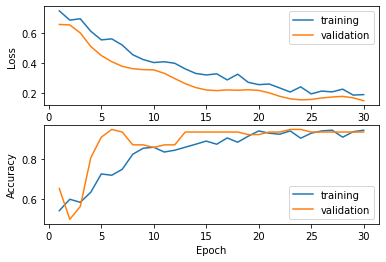

In [10]:
# PLOTTING LOSS AND ACCURACY DURING TRAINING:

%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.figure(1)
plt.subplot(211)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')

epoch_nums = range(1,num_epochs+1)
training_accuracy = history.history["acc"]
validation_accuracy = history.history["val_acc"]
plt.subplot(212)
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

Generating predictions from validation data...


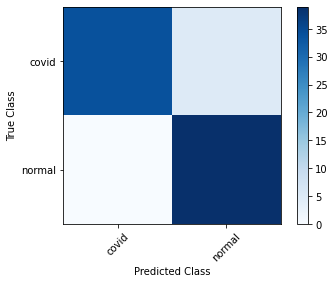

Confusion Matrix:
[[34  5]
 [ 0 39]]
Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.87      0.93        39
      normal       0.89      1.00      0.94        39

    accuracy                           0.94        78
   macro avg       0.94      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78



In [11]:
# CONFUSION MATRIX and CLASSIFICATION REPORT FOR TEST DATA:

validation_generator.reset()

print("Generating predictions from validation data...")
Y_pred = model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = Y_pred > 0.5
y_true = validation_generator.classes
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
target_names = list(train_generator.class_indices)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
#saving final model
model.save("final_model.h5")

In [ ]:
#saving final model weights
model.save_weights("final_model_weights.h5")

In [ ]:
import shutil

shutil.make_archive('data/test', 'zip', 'data/test')


'/content/data/test.zip'

In [ ]:
from google.colab import files

files.download('/content/data/test.zip')